# Machine Learning Practical: Earthquake Classification:

In this exercise our aim is to classify felt from not-felt earthquakes in Japan from a seismic catalogue.

## Reading the dataset
This dataset is from the catalogue of Japanese earthquake produced by the JMA (Japan Meteorological Agency)

The catalogue contains the following information
1) id : id of the event	
2) hour : Hour of the day when the earthquake occured
3) lat	: latitude of the event in degrees
4) lon	: longitude of the event in degrees
5) mag	: magnitude of the event
6) depth : depth of the event	
7) nsta : number of stations used to locate the event
8) label : 1 felt 0 not-felt

In [1]:
import pandas as pd
from pandas import set_option
set_option("display.max_rows", 25)

pd.options.mode.chained_assignment = None
eqk_data = pd.read_csv('jp_eqk_train.csv')
eqk_data_blind = pd.read_csv('jp_eqk_blind.csv')
eqk_data

,id,hour,lat,lon,mag,depth,nsta,label
0,1,7,34.1470,135.1607,3.4,8.6,33,1
1,2,3,31.8363,130.2910,3.1,5.9,25,1
2,3,11,28.0560,130.4255,4.2,26.9,11,1
3,4,12,28.1238,130.3577,4.5,34.8,21,1
4,7,2,35.6165,140.2328,5.0,78.0,40,1
...,...,...,...,...,...,...,...,...
3995,23516,22,36.1320,140.0163,3.3,48.0,35,0
3996,23529,1,37.0158,140.6923,3.5,9.3,20,0
3997,23533,4,36.9553,140.7043,3.3,8.5,20,0
3998,23546,9,37.1232,140.7023,2.9,6.5,20,0


## Organinzing and Visualizing the Dataset
Now we need to split the dataset into training and test data.

In [2]:
training = eqk_data
blind = eqk_data_blind


Before plotting data, we define a color map for the earthuakes that will help us when visualizing the dataset.

In [3]:
eqk_colors = ['#F4D03F', '#2E86C1']
eqk_labels = ['not felt', 'felt']
eqk_color_map = {}
for ind, label in enumerate(eqk_labels):
    eqk_color_map[label] = eqk_colors[ind]

def label_eqk(row, labels):
    ilab=int(row['label'])
    return labels[ ilab ]
    
training.loc[:,'eqk_labels'] = training.apply(lambda row: label_eqk(row, eqk_labels), axis=1)
training.describe()

,id,hour,lat,lon,mag,depth,nsta,label
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,6770.576000,11.688500,35.964127,138.668135,3.512825,23.592525,26.635500,0.500000
std,6755.776104,6.831225,3.349503,3.894390,1.009241,31.380617,9.651369,0.500063
min,1.000000,0.000000,22.379500,121.464000,0.000000,0.000000,3.000000,0.000000
25%,1752.750000,6.000000,34.179300,138.568800,2.800000,8.400000,20.000000,0.000000
50%,3432.500000,12.000000,35.480850,139.322350,3.500000,13.600000,25.000000,0.500000
75%,11283.500000,18.000000,37.417200,140.919375,4.200000,32.625000,36.000000,1.000000
max,23550.000000,23.000000,46.974300,155.052200,8.200000,551.800000,80.000000,1.000000


In addition to individual wells, we can look at how the various events are represented by the entire training set.  Let's plot a histgram of the number of training examples for each event class this is usefult to check if we have a class imbalance problem.

<AxesSubplot:title={'center':'Eqk data distribution'}>

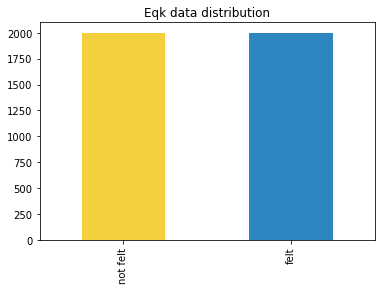

In [4]:
eqk_counts = training['label'].value_counts().sort_index()
eqk_counts.index = eqk_labels

eqk_counts.plot(kind='bar',color=eqk_colors, title='Eqk data distribution')

We are now goint to use a crossplot to visualize how a variable of the dataset changes with respect to the other ones. The scatter matrix can help to quickly visualize the variation between the all the variables in the dataset.

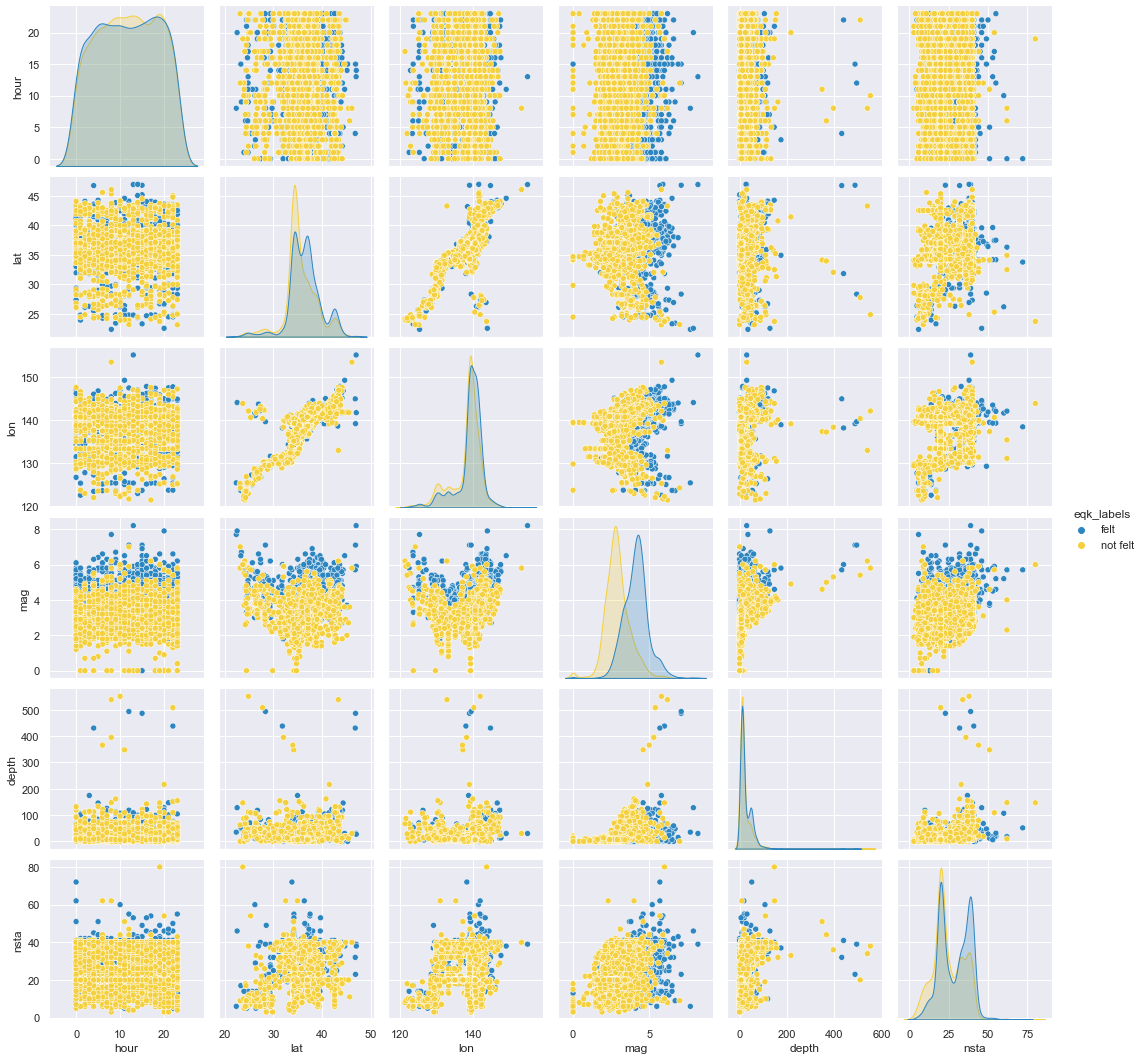

In [5]:
import seaborn as sns
sns.set()
sns.pairplot(training.drop(['id','label'],axis=1),
             hue='eqk_labels', palette=eqk_color_map,
             hue_order=list(reversed(eqk_labels)))

## Scaling the dataset
The data will be scaled to have zero mean and unit variance (standardization). We will also split the data into training and test sets. We also extract just the feature variables we need to perform the classification. 

In [6]:
correct_eqk_labels = training['label'].values
feature_vectors = training.drop(['id','label','nsta','hour','eqk_labels'], axis=1)
feature_vectors.describe()

,lat,lon,mag,depth
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,35.964127,138.668135,3.512825,23.592525
std,3.349503,3.894390,1.009241,31.380617
min,22.379500,121.464000,0.000000,0.000000
25%,34.179300,138.568800,2.800000,8.400000
50%,35.480850,139.322350,3.500000,13.600000
75%,37.417200,140.919375,4.200000,32.625000
max,46.974300,155.052200,8.200000,551.800000


The Scikit-learn library includes a [preprocessing](http://scikit-learn.org/stable/modules/preprocessing.html) module that can 'standardize' the data, the `StandardScaler` class, that gives each variable zero mean and unit variance.  The factors used to standardize the training set must be applied to any subsequent feature set that will be input to the classifier.   can be fit to the training set, and later used to standardize any training data.

In [7]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)

In [8]:
feature_vectors

,lat,lon,mag,depth
0,34.1470,135.1607,3.4,8.6
1,31.8363,130.2910,3.1,5.9
2,28.0560,130.4255,4.2,26.9
3,28.1238,130.3577,4.5,34.8
4,35.6165,140.2328,5.0,78.0
...,...,...,...,...
3995,36.1320,140.0163,3.3,48.0
3996,37.0158,140.6923,3.5,9.3
3997,36.9553,140.7043,3.3,8.5
3998,37.1232,140.7023,2.9,6.5


Scikit also includes a function to randomly split the training data into training and test sets.  The test set contains a small subset of feature vectors that are not used to train the model.

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        scaled_features, correct_eqk_labels, test_size=0.2, random_state=42)

## Training our first Machine Learning Algorithm

After data are ready to be used. We use different SVM and KNN to performs the classiication  

In [10]:
from sklearn import svm

def classification(X_train, y_train, method='LGS', *params):
    if method=='LGS':
        clf= LogisticRegression(C=params[0])
    elif method=='KNN':
        clf=KNeighborsClassifier(n_neighbors=params[0])
    elif method=='SVM':
        clf=svm.SVC(kernel=params[0])
    return clf

model='SVM'
param='rbf'
clf=classification(X_train, y_train, model, param)

Now you can train and optimize the classifier using the training set we created above.

In [11]:
clf.fit(X_train,y_train)
predicted_labels = clf.predict(X_test)

We need some metrics to evaluate how good our classifier is doing, here we use the [accuracy-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) implemented in scikit.
Try to plot the confusion matrix and calculate the different scores to evaluate the performace of the classifier.

In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix

accuracy=accuracy_score(y_test, predicted_labels)  #do you understand the difference between this
scr=clf.score(X_test,y_test) # and this

print('Eqk classification accuracy = %f'%accuracy)
print('Eqk classification score = %f'%scr)

y_pred=clf.predict(X_test)
C=confusion_matrix(y_test, y_pred)
print('Confusion Matrix')
print(C)

Eqk classification accuracy = 0.870000
Eqk classification score = 0.870000
Confusion Matrix
[[325  53]
 [ 51 371]]


In [13]:
y_blind = blind['label'].values
eqk_features = blind.drop(['id','label','nsta','hour'], axis=1)
X_blind = scaler.transform(eqk_features)
y_pred = clf.predict(X_blind)
accuracy_blind=accuracy_score(y_blind, y_pred)

print('accuracy for blind test = %.2f' %accuracy_blind)

accuracy for blind test = 0.89
